Imports

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 60)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, ndcg_score, make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer, minmax_scale
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.wsd import lesk
from nltk.parse import CoreNLPParser
import syllables
lemmatizer = WordNetLemmatizer() 
from lib.InferSent.models import InferSent
import csv
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import rankdata, pearsonr, spearmanr, stats
from itertools import combinations, chain
import pickle as pkl
from transformers import BertTokenizer
import json
import matplotlib.pyplot as plt
import os
import ast
import textstat
import inspect
import stanfordnlp
from lib.utils import *
from bs4 import BeautifulSoup
import re
import readability
import math
import urllib 
import requests
import time
from mlxtend.feature_selection import SequentialFeatureSelector

[nltk_data] Downloading package wordnet to /Users/pickle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pickle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pickle/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pickle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/pickle/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [7]:
job = 'pickle'
path = './data/'+job
if not os.path.isdir(path): os.mkdir(path)
if not os.path.isdir(path+'/discovery'): os.mkdir(path+'/discovery')
if not os.path.isdir(path+'/colab'): os.mkdir(path+'/colab')

# Unprocessed data goes here:

Data

In [8]:
single_train = pd.read_csv('./lib/CompLex/train/lcp_single_train.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)
single_trial = pd.read_csv('./lib/CompLex/trial/lcp_single_trial.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)
multi_train = pd.read_csv('./lib/CompLex/train/lcp_multi_train.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)
multi_trial = pd.read_csv('./lib/CompLex/trial/lcp_multi_trial.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)

In [41]:
single_test = pd.read_csv('./lib/CompLex/test-labels/lcp_single_test.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)
multi_test = pd.read_csv('./lib/CompLex/test-labels/lcp_multi_test.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)

In [150]:
single_train['task'] = 'single'
single_trial['task'] = 'single'
single_test['task'] = 'single'
single_train['split'] = 'train'
single_trial['split'] = 'trial'
single_trial = single_trial.rename(columns={'subcorpus': 'corpus'})
single_test['split'] = 'test'
multi_train['task'] = 'multi'
multi_trial['task'] = 'multi'
multi_test['task'] = 'multi'
multi_train['split'] = 'train'
multi_trial['split'] = 'trial'
multi_trial = multi_trial.rename(columns={'subcorpus': 'corpus'})
multi_test['split'] = 'test'
data = single_train.append(single_trial).append(single_test).append(multi_train).append(multi_trial).append(multi_test)

In [151]:
data_reshaped = data.groupby(['corpus', 'task', 'split']).size().unstack()
data_reshaped = data_reshaped[['train', 'trial', 'test']]
data_reshaped = data_reshaped.reindex(['single', 'multi'], level='task')

In [160]:
print(data_reshaped.to_latex())

\begin{tabular}{llrrr}
\toprule
         & split &  train &  trial &  test \\
corpus & task &        &        &       \\
\midrule
bible & single &   2574 &    143 &   283 \\
         & multi &    505 &     29 &    66 \\
biomed & single &   2576 &    135 &   289 \\
         & multi &    514 &     33 &    53 \\
europarl & single &   2512 &    143 &   345 \\
         & multi &    498 &     37 &    65 \\
\bottomrule
\end{tabular}



In [152]:
data_reshaped.append()

split            train  trial  test
corpus   task                      
bible    single   2574    143   283
         multi     505     29    66
biomed   single   2576    135   289
         multi     514     33    53
europarl single   2512    143   345
         multi     498     37    65

In [158]:
data_reshaped.groupby(level='task').sum().reindex(['single', 'multi'])

split,train,trial,test
task,,,
single,7662,421,917
multi,1517,99,184


Preprocess

In [4]:
preprocess(single_train, './data/'+job+'/single_train_p.tsv')
preprocess(single_trial, './data/'+job+'/single_trial_p.tsv')
preprocess(multi_train, './data/'+job+'/multi_train_p.tsv')
preprocess(multi_trial, './data/'+job+'/multi_trial_p.tsv')

In [10]:
preprocess(single_test, './data/'+job+'/single_test_p.tsv')
preprocess(multi_test, './data/'+job+'/multi_test_p.tsv')

In [7]:
#preprocess_for_bert(single_train, job, 'single_train', do_round=False)
#preprocess_for_bert(single_trial, job, 'single_trial', do_round=False)
preprocess_for_bert(multi_train, job, 'multi_train', do_round=False, do_split_token=True)
preprocess_for_bert(multi_trial, job, 'multi_trial', do_round=False, do_split_token=True)

In [34]:
preprocess_for_bert(single_test, job, 'single_test', do_round=False)
preprocess_for_bert(multi_test, job, 'multi_test', do_round=False)

# Processed data goes here:

In [3]:
single_train = pd.read_csv('./data/'+job+'/single_train_p.tsv', sep='\t', index_col=0)
single_trial = pd.read_csv('./data/'+job+'/single_trial_p.tsv', sep='\t', index_col=0)
multi_train = pd.read_csv('./data/'+job+'/multi_train_p.tsv', sep='\t', index_col=0)
multi_trial = pd.read_csv('./data/'+job+'/multi_trial_p.tsv', sep='\t', index_col=0)

In [ ]:
single_test = pd.read_csv('./data/'+job+'/single_test_p.tsv', sep='\t', index_col=0)
multi_test = pd.read_csv('./data/'+job+'/multi_test_p.tsv', sep='\t', index_col=0)

# Extract features

Do once and forget about it.

In [15]:
config = {
    'glove_path': './lib/glove/glove.6B.300d.txt',
    'glove_lower': True,
    'disambiguate': True,
    'infersent_V': 1,
    'infersent_MODEL_PATH': './lib/encoder/infersent%s.pkl',
    'infersent_W2V_PATH': './lib/glove/glove.6B.300d.txt',
    'infersent_lower': True,
    'options_file': './lib/ELMo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json',
    'weight_file': './lib/ELMo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'
}

In [17]:
glove_embeddings = build_glove_embeddings(config)

400000it [00:36, 11020.83it/s]


In [7]:
%%time
save_embeddings(single_train, glove_embeddings, config, './data/'+job+'/single_train_d.tsv')
save_embeddings(single_trial, glove_embeddings, config, './data/'+job+'/single_trial_d.tsv')
save_embeddings(multi_train, glove_embeddings, config, './data/'+job+'/multi_train_d.tsv', multi=True)
save_embeddings(multi_trial, glove_embeddings, config, './data/'+job+'/multi_trial_d.tsv', multi=True)

Found 6832(/7561) words with w2v vectors
Vocab size : 6832
100%|██████████| 16/16 [05:47<00:00, 21.74s/it]
Found 6832(/7561) words with w2v vectors
Vocab size : 6832
100%|██████████| 16/16 [05:47<00:00, 21.71s/it]
Found 1211(/1271) words with w2v vectors
Vocab size : 1211
100%|██████████| 1/1 [00:23<00:00, 23.79s/it]
Found 1211(/1271) words with w2v vectors
Vocab size : 1211
100%|██████████| 1/1 [00:21<00:00, 21.89s/it]
CPU times: user 15min 18s, sys: 2min 34s, total: 17min 53s
Wall time: 18min 10s


In [18]:
%%time
save_embeddings(single_test, glove_embeddings, config, './data/'+job+'/single_test_d.tsv')
save_embeddings(multi_test, glove_embeddings, config, './data/'+job+'/multi_test_d.tsv', multi=True)

Found 5097(/5609) words with w2v vectors
Vocab size : 5097
100%|██████████| 10/10 [04:39<00:00, 27.97s/it]
Found 1775(/1860) words with w2v vectors
Vocab size : 1775
100%|██████████| 2/2 [00:47<00:00, 23.74s/it]
Found 1775(/1860) words with w2v vectors
Vocab size : 1775
  4%|▍         | 8/184 [00:00<00:05, 33.88it/s]
CPU times: user 5min 54s, sys: 1min 18s, total: 7min 12s
Wall time: 8min 1s


Run the cells below for a dataset to obtain its parse_lst. 

Before running these cells:
- Set `data = name_of_dataset`.
- Open terminal and `cd` into `./lib/stanford-corenlp-4.2.0`.
- Run the following: `java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -preload tokenize,ssplit,pos,lemma,ner,parse,depparse -status_port 9000 -port 9000 -timeout 15000000 & `

While running these cells:
- If error arises, assess situation, add to `exceptions` if need be, and resume by adjusting `idx`.

After running these cells:
- Run the following: `ps aux | grep StanfordCoreNLPServer`.


In [39]:
single_train = pd.read_csv('./data/'+job+'/single_train_d.tsv', sep='\t', index_col=0)
single_trial = pd.read_csv('./data/'+job+'/single_trial_d.tsv', sep='\t', index_col=0)
multi_train = pd.read_csv('./data/'+job+'/multi_train_d.tsv', sep='\t', index_col=0)
multi_trial = pd.read_csv('./data/'+job+'/multi_trial_d.tsv', sep='\t', index_col=0)

In [19]:
single_test = pd.read_csv('./data/'+job+'/single_test_d.tsv', sep='\t', index_col=0)
multi_test = pd.read_csv('./data/'+job+'/multi_test_d.tsv', sep='\t', index_col=0)

In [47]:
data, path = multi_test, './data/'+job+'/multi_test_parse_lst.pkl'

In [ ]:
parser = CoreNLPParser(url='http://localhost:9000')

In [ ]:
'foo'

In [49]:
data['sentence'] = data['sentence'].apply(lambda x: clean_sentence(x))

In [50]:
exceptions = {'3BFF0DJK8XCEIOT30ZLBPPSRM1VSTL': "Welcomes the G8 leaders' statement on Zimbabwe of 8 July, in particular their recommendation to appoint a Special Envoy of the UN Secretary-General to report on the political, humanitarian, human rights and security situation and to support regional efforts to take forward mediation between political parties while respecting the results of the 29 March 2008 election, and their intention to take further steps, inter alia introducing financial and other measures against those individuals responsible for violence.", '3LAZVA75NIR50X7XA3K64X90PYWO27': 'Τhe next item is the oral question to the Commission (B7-0240/2009) by Silvia-Adriana Ţicău, Brian Simpson, János Áder, Hannes Swoboda, Eva Lichtenberger, Michael Cramer, Saïd El Khadraoui, Mathieu Grosch, Iuliu Winkler, Victor Boştinaru, Ioan Mircea Paşcu, Marian-Jean Marinescu, Ivailo Kalfin, Norica Nicolai, Dirk Sterckx, Csaba Sándor Tabajdi, Michael Theurer, Ismail Ertug, Inés Ayala Sender, Jiří Havel, Edit Herczog, Stanimir Ilchev, Iliana Malinova Iotova, Jelko Kacin, Evgeni Kirilov, Ádám Kósa, Ioan Enciu, Eduard Kukan, Gesine Meissner, Alajos Mészáros, Nadezhda Neynsky, Katarína Neveďalová, Daciana Octavia Sârbu, Vilja Savisaar, Olga Sehnalová, Catherine Stihler, Peter van Dalen, Louis Grech, Corina Creţu, Adina-Ioana Vălean and Rovana Plumb, on the European Strategy for the Danube Region.'}

In [51]:
parse_lst = []
skip = True
for idx, row in tqdm(data.iterrows()):
    if idx == 0:
        skip = False
    if skip:
        continue
    if row['id'] in exceptions:
        sentence = exceptions[row['id']]
    else:
        sentence = row['sentence']
    parse_lst.append(next(parser.raw_parse(sentence)))

184it [02:21,  1.30it/s]


In [ ]:
sentence, row['token'], row['id'], idx

In [ ]:
next(parser.raw_parse('...'))

In [53]:
len(parse_lst)

184

In [54]:
pkl.dump(parse_lst, open(path, 'wb'))

Other features

In [3]:
single_train = pd.read_csv('./data/'+job+'/single_train_d.tsv', sep='\t', index_col=0)
single_trial = pd.read_csv('./data/'+job+'/single_trial_d.tsv', sep='\t', index_col=0)
multi_train = pd.read_csv('./data/'+job+'/multi_train_d.tsv', sep='\t', index_col=0)
multi_trial = pd.read_csv('./data/'+job+'/multi_trial_d.tsv', sep='\t', index_col=0)

In [55]:
single_test = pd.read_csv('./data/'+job+'/single_test_d.tsv', sep='\t', index_col=0)
multi_test = pd.read_csv('./data/'+job+'/multi_test_d.tsv', sep='\t', index_col=0)

In [6]:
%%time
save_other_features(single_train, './data/'+job+'/single_train_parse_lst.pkl', config, './data/'+job+'/single_train_o.tsv')
save_other_features(single_trial, './data/'+job+'/single_trial_parse_lst.pkl', config, './data/'+job+'/single_trial_o.tsv')
save_other_features(multi_train, './data/'+job+'/multi_train_parse_lst.pkl', config, './data/'+job+'/multi_train_o.tsv', multi=True)
save_other_features(multi_trial, './data/'+job+'/multi_trial_parse_lst.pkl', config, './data/'+job+'/multi_trial_o.tsv', multi=True)

100%|██████████| 34/34 [00:11<00:00,  2.86it/s]
7659it [00:29, 258.72it/s]
100%|██████████| 34/34 [00:00<00:00, 46.87it/s]
421it [00:01, 250.06it/s]
100%|██████████| 34/34 [00:02<00:00, 13.86it/s]
1517it [00:05, 252.92it/s]
100%|██████████| 34/34 [00:02<00:00, 14.57it/s]
1517it [00:06, 251.28it/s]
100%|██████████| 34/34 [00:00<00:00, 160.88it/s]
99it [00:00, 248.10it/s]
100%|██████████| 34/34 [00:00<00:00, 135.56it/s]
99it [00:00, 236.36it/s]
 77%|███████▋  | 76/99 [00:00<00:00, 868.69it/s]
CPU times: user 1min 51s, sys: 3.03 s, total: 1min 54s
Wall time: 2min 1s


In [58]:
save_other_features(single_test, './data/'+job+'/single_test_parse_lst.pkl', config, './data/'+job+'/single_test_o.tsv')
save_other_features(multi_test, './data/'+job+'/multi_test_parse_lst.pkl', config, './data/'+job+'/multi_test_o.tsv', multi=True)

100%|██████████| 34/34 [00:02<00:00, 15.99it/s]
917it [00:03, 232.72it/s]
100%|██████████| 34/34 [00:00<00:00, 95.53it/s]
184it [00:00, 230.32it/s]
100%|██████████| 34/34 [00:00<00:00, 90.97it/s]
184it [00:00, 245.48it/s]
 40%|████      | 74/184 [00:00<00:00, 805.38it/s]


Create log-transformed features

In [3]:
single_train = pd.read_csv('./data/'+job+'/single_train_o.tsv', sep='\t', index_col=0)
single_trial = pd.read_csv('./data/'+job+'/single_trial_o.tsv', sep='\t', index_col=0)
multi_train = pd.read_csv('./data/'+job+'/multi_train_o.tsv', sep='\t', index_col=0)
multi_trial = pd.read_csv('./data/'+job+'/multi_trial_o.tsv', sep='\t', index_col=0)

In [3]:
single_test = pd.read_csv('./data/'+job+'/single_test_o.tsv', sep='\t', index_col=0)
multi_test = pd.read_csv('./data/'+job+'/multi_test_o.tsv', sep='\t', index_col=0)

In [7]:
%%time
log_transform(single_train, 'all', './data/'+job+'/single_train_o.tsv')
log_transform(single_trial, 'all', './data/'+job+'/single_trial_o.tsv')
log_transform(multi_train, 'all', './data/'+job+'/multi_train_o.tsv')
log_transform(multi_trial, 'all', './data/'+job+'/multi_trial_o.tsv')

CPU times: user 24.7 s, sys: 982 ms, total: 25.7 s
Wall time: 28.3 s


In [61]:
%%time
log_transform(single_test, 'all', './data/'+job+'/single_test_o.tsv')
log_transform(multi_test, 'all', './data/'+job+'/multi_test_o.tsv')

CPU times: user 3.71 s, sys: 294 ms, total: 4.01 s
Wall time: 7.5 s


## Outgoing to discovery

# Playground

## Parse tree

In [73]:
single_test = pd.read_csv('./data/'+job+'/single_test_p.tsv', sep='\t', index_col=0)
path = './data/pickle/parse_lst_dir/inputs/'

In [74]:
import stanza
stanza.download('en')       # This downloads the English models for the neural pipeline

2021-02-16 22:36:37 INFO: Downloading default packages for language: en (English)...
2021-02-16 22:36:39 INFO: File exists: /Users/pickle/stanza_resources/en/default.zip.
2021-02-16 22:36:43 INFO: Finished downloading models and saved to /Users/pickle/stanza_resources.


In [75]:
tokens_lst = pkl.load('./data/pickle/tokens_lst.pkl')

917it [00:00, 33778.99it/s]


In [76]:
results = []
nlp = stanza.Pipeline('en',  processors='tokenize,mwt,pos,lemma,depparse') # This sets up a default neural pipeline in English
with open('./data/pickle/sentences.txt', 'r') as file:
    for line in tqdm(file):
        sentence = line.rstrip('\n')
        doc = nlp(sentence)
        results.append([(word.text, word.head, word.deprel) for sentence in doc.sentences for word in sentence.words])

2021-02-16 22:36:55 WARNING: Can not find mwt: default from official model list. Ignoring it.
2021-02-16 22:36:55 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2021-02-16 22:36:55 INFO: Use device: cpu
2021-02-16 22:36:55 INFO: Loading: tokenize
2021-02-16 22:36:55 INFO: Loading: pos
2021-02-16 22:36:55 INFO: Loading: lemma
2021-02-16 22:36:55 INFO: Loading: depparse
2021-02-16 22:36:56 INFO: Done loading processors!
917it [04:57,  3.08it/s]


In [77]:
pkl.dump(results, open('./data/pickle/depparse.pkl', 'wb'))

In [6]:
os.environ["CORENLP_HOME"] = '/Users/pickle/cs99/Lexical_Complexity_Prediction/lib/stanford-corenlp-4.2.0'

In [ ]:
anns = []

In [13]:
from stanza.server import CoreNLPClient
with CoreNLPClient(
    annotators=['tokenize','ssplit','pos','lemma','ner', 'parse', 'depparse','coref'],
    timeout=300000,
    memory='16G') as client:
    for i, sentence in tqdm(enumerate(sentences)):
        if i < 94:
            continue
        ann = client.annotate(sentence)
        anns.append(ann)

2021-02-15 00:31:32 INFO: Writing properties to tmp file: corenlp_server-c4aa2011b0b544bf.props
2021-02-15 00:31:32 INFO: Starting server with command: java -Xmx16G -cp /Users/pickle/cs99/Lexical_Complexity_Prediction/lib/stanford-corenlp-4.2.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 300000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties corenlp_server-c4aa2011b0b544bf.props -annotators tokenize,ssplit,pos,lemma,ner,parse,depparse,coref -preload -outputFormat serialized
766it [17:02,  1.33s/it]


In [60]:
for i in range(len(anns)):
    offset = 0
    rules = []
    for sentence in anns[i].sentence:
        print('___________________')
        print('dependency parse:')
        dp = sentence.basicDependencies
        token_dict = {sentence.token[i].tokenEndIndex-offset : sentence.token[i].word for i in range(0, len(sentence.token))}
        
        offset += len(sentence.token)
        # build list of (source, target) pairs
        out_parse = [(dp.edge[i].source, dp.edge[i].target, dp.edge[i].dep) for i in range(0, len(dp.edge))]
        for source, target, dep in out_parse:
            print(source, token_dict[source], '->', target, token_dict[target], dep)
        break
    break

___________________
dependency parse:
2 CLS -> 1 [ punct
2 CLS -> 17 aspire parataxis
2 CLS -> 3 ] punct
2 CLS -> 35 . punct
7 Council -> 6 the det
12 view -> 10 in case
12 view -> 11 the det
12 view -> 15 House nmod
15 House -> 13 of case
15 House -> 14 this det
17 aspire -> 16 , punct
17 aspire -> 19 achieve xcomp
17 aspire -> 4 Incidentally advmod
17 aspire -> 5 , punct
17 aspire -> 7 Council nsubj
17 aspire -> 8 should aux
17 aspire -> 9 , punct
17 aspire -> 12 view obl
19 achieve -> 32 relations obl
19 achieve -> 18 to mark
19 achieve -> 21 transparency obj
19 achieve -> 28 area obl
21 transparency -> 20 more amod
25 important -> 27 comprehensive conj
27 comprehensive -> 26 and cc
28 area -> 22 in case
28 area -> 23 such det:predet
28 area -> 24 an det
28 area -> 25 important amod
28 area -> 30 policy nmod
30 policy -> 29 of case
32 relations -> 34 Russia nmod
32 relations -> 31 as case
34 Russia -> 33 with case


## Mutual information

In [57]:
feature_names, mi = get_sorted_mi('./data/'+job+'/discovery/single_train_mi.txt')

Text(0.5, 1.0, 'Top-20 Mutual Information Scores')

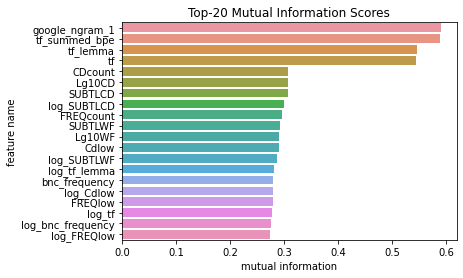

In [58]:
i = 20
idx = [j for j in range(len(feature_names)) if feature_names[j] not in ['log_FREQcount', 'log_CDcount']]
sns.reset_orig()
ax = sns.barplot(x=np.array(mi)[idx][:i], y=np.array(feature_names)[idx][:i])
ax.set_xlabel('mutual information')
ax.set_ylabel('feature name')
ax.set_title('Top-20 Mutual Information Scores')
#sns.set(rc={'figure.figsize':(11.7,8.27)})

## Context

In [107]:
single_train = pd.read_csv('./data/'+job+'/single_train_o.tsv', sep='\t', index_col=0)
single_trial = pd.read_csv('./data/'+job+'/single_trial_o.tsv', sep='\t', index_col=0)
single_trial['bert_pred_complexity'] = json.load(open('./data/pickle/colab/single_trial_bert_scores.json', 'r'))['scores']

In [108]:
single_train.sort_values('complexity', inplace=True)
single_trial.sort_values('complexity', inplace=True)

In [132]:
single_train.groupby('token').apply(lambda x: x['complexity'].max()-x['complexity'].min()).sort_values(ascending=False)

token
byword       0.552273
search       0.475000
activity     0.400000
disease      0.388889
thrombus     0.356061
               ...   
conceit      0.000000
LAG          0.000000
Technical    0.000000
LN           0.000000
doctrines    0.000000
Length: 3486, dtype: float64

In [142]:
single_train[single_train['token']=='activity'][['sentence', 'token', 'complexity']]

,sentence,token,complexity
2683,BMP2 and BMP7 are thus secondary signals produced in response to SHH activity.,activity,0.050000
2684,"Because synapsis occurs in TRIP13-deficient spermatocytes and is dependent on DSB formation (activity of SPO11 and MEI1), we suggest that TRIP13 functions after homology recognition and strand exchange, and that recombination events entering the CO repair pathway are either completed or nearly so (because OA treated resulted in bivalent chromosomes).",activity,0.140625
2685,"However, again we were unable to generate ES cells or mice exhibiting robust widespread reporter activity (A.-K.H. and V.E. Papaioannou, unpublished observations).",activity,0.176471
2686,"Previous studies have shown that the alpha-crystallin possesses molecular chaperone activity, binding to partially denatured proteins, both in vitro [5] and probably in vivo [6], to inhibit further denaturation.",activity,0.235294
2687,Initial studies targeted Capn4 based on the prediction that loss of this calpain subunit would abolish activity of both μ- and m-calpain.,activity,0.450000


In [109]:
single_trial.groupby('token').apply(lambda x: x['complexity'].max()-x['complexity'].min()).sort_values(ascending=False)

token
microscopy      0.257292
peptide         0.251736
antigen         0.233696
condensation    0.225564
sea             0.220588
                  ...   
creature        0.000000
cyclone         0.000000
derangement     0.000000
detection       0.000000
wrongdoing      0.000000
Length: 213, dtype: float64

In [124]:
single_trial.groupby('token').size().sort_values(ascending=False).head(20)

token
microscopy       5
peptide          5
Lord             5
epithelium       5
dwellings        5
observation      5
hyperactivity    5
organisations    5
Estonia          5
position         5
priests          5
covenant         5
signals          5
land             5
anger            5
faithfulness     5
controls         5
authorities      5
sea              5
proteins         5
dtype: int64

In [125]:
single_trial.groupby('token').apply(lambda x: np.abs(pearson(x['complexity'], x['bert_pred_complexity'])) if x.shape[0] >= 3 else 0).sort_values(ascending=False).head(20)

token
consequences     0.998852
room             0.997786
peptide          0.989644
bone             0.976555
command          0.976015
wings            0.954484
wording          0.953453
programme        0.931271
possibility      0.924323
authorisation    0.907891
Dagon            0.893489
partnership      0.888797
Lord             0.874990
controls         0.850894
Estonia          0.818223
Enoch            0.812330
virginity        0.788772
sea              0.784655
hyperactivity    0.772267
land             0.761802
dtype: float64

In [131]:
single_trial[single_trial['token']=='wings'][['sentence', 'token', 'complexity', 'bert_pred_complexity']]

,sentence,token,complexity,bert_pred_complexity
14,"He shall tear it by its wings, but shall not divide it apart.",wings,0.075000,0.209142
15,"Don't curse the king, no, not in your thoughts; and don't curse the rich in your bedroom: for a bird of the sky may carry your voice, and that which has wings may tell the matter.",wings,0.152778,0.278196
16,"How often I would have gathered your children together, even as a hen gathers her chicks under her wings, and you would not!",wings,0.223684,0.480439


In [80]:
pd.set_option('display.max_colwidth', -1)

## Mutual information

Text(0, 0.5, 'Pearson')

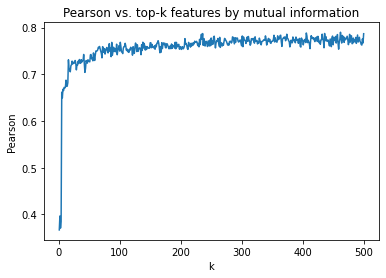

In [69]:
(feature_names, mi, k_lst, pearson_lst, single_train_feature_name_2_idx, X_train_mini, X_dev_mini, y_train_mini, y_dev_mini) = pkl.load(open('stuff.pkl', 'rb'))
X = np.vstack((X_train_mini, X_dev_mini))
y = np.hstack((y_train_mini, y_dev_mini))

k_lst, pearson_lst = [], []

for k in tqdm(np.arange(101, 500+1, 1)):
    k_lst.append(k)
    picks = feature_names[:k]
    col_idx = [single_train_feature_name_2_idx[pick] for pick in picks]
    X_picks = X[:, col_idx]
    model = LinearRegression()
    p_s = cross_val_score(model, X_picks, y, scoring=make_scorer(pearson), cv=custom_cv_folds(single_train, n_splits=5))
    p = np.mean(p_s)
    pearson_lst.append(p)

plt.plot(k_lst, pearson_lst)
plt.title('Pearson vs. top-k features by mutual information')
plt.xlabel('k')
plt.ylabel('Pearson')

## Foreign data

In [117]:
df = pd.read_csv('./lib/lexical_simplification-master/word_complexity_lexicon/lexicon.tsv', sep='\t', names=['token', 'complexity'])

In [118]:
df['complexity'] = df['complexity']/6

In [119]:
df.head()

,token,complexity
0,wet,0.261900
1,cargo,0.476183
2,Arsenal,0.619050
3,Manufacturing,0.638883
4,East,0.214283


In [120]:
single_train['found'] = single_train['token'].isin(df['token'])

In [121]:
single_train = pd.merge(single_train, df, on='token', how='left')

In [122]:
single_train[single_train['found']][['token', 'found', 'complexity_x', 'complexity_y']].corr()

,found,complexity_x,complexity_y
found,NaN,NaN,NaN
complexity_x,NaN,1.000000,0.541476
complexity_y,NaN,0.541476,1.000000


# Mo' features
- Google N-grams
    - Eg. "the **happy** man"
    - Decision: "the **happy**" TF correlates better with complexity than "**happy** man". 
    - Special thanks to PhraseFinder API.
    - google_tf
    - google_tf_ngram_2_head
    - google_tf_ngram_2_tail
    - google_tf_ngram_2_min
    - google_tf_ngram_2_max
    - google_tf_ngram_2_mean
    - google_tf_ngram_2_std
    - google_tf_ngram_3_head
    - google_tf_ngram_3_mid
    - google_tf_ngram_3_tail
    - google_tf_ngram_3_min
    - google_tf_ngram_3_max
    - google_tf_ngram_3_mean
    - google_tf_ngram_3_std
- SUBTLEX
    - FREQcount
    - CDcount
    - FREQlow
    - CDlow
    - SUBTLWF
    - Lg10WF
    - SUBTLCD
    - Lg10CD
- BNC
    - frequency
    - variance (omitted, too many NaN's)
- Phoneme transition probability
    - phoneme_transition_min
    - phoneme_transition_max
    - phoneme_transition_mean
    - phoneme_transition_std
- Char transition probability
    - char_transition_min
    - char_transition_max
    - char_transition_mean
    - char_transition_std


In [9]:
multi_train = pd.read_csv('./data/pickle/multi_train_o.tsv', sep='\t', index_col=0)

In [17]:
multi_train_head = multi_train.copy()
multi_train_head['token'] = multi_train_head['token'].apply(lambda x: x.split(' ')[0])
multi_train_tail = multi_train.copy()
multi_train_tail['token'] = multi_train_tail['token'].apply(lambda x: x.split(' ')[1])

In [21]:
N = 1
data = multi_train
google_ngram = np.zeros((len(data), N))
go = False
for j, (idx, row) in tqdm(enumerate(data.iterrows())):
    if j == 1066:
        go = True
    if not go:
        continue
    token = row['token']
    sentence = row['sentence']
    ngrams_lst = get_ngrams(sentence, token, N)
    for i in range(len(ngrams_lst)):
        if i >= google_ngram.shape[1]:
            continue
        google_ngram[j, i] = get_tf(ngrams_lst[i])

1517it [11:38,  2.17it/s]


In [323]:
single_trial = pd.read_csv('./data/'+job+'/single_trial_p.tsv', sep='\t', index_col=0)

In [30]:
np.save('./data/pickle/multi_train_google_ngram_3_tail.npy', google_ngram)

In [324]:
tokens = set(single_trial['token'])
token_2_mc = {}
for token in tqdm(tokens):
    token_2_mc[token] = get_tf(token)
    time.sleep(0.001)

100%|██████████| 213/213 [02:40<00:00,  1.32it/s]


In [325]:
google_ngram = single_trial['token'].apply(lambda x: token_2_mc[x]).to_numpy()

# SFS

In [53]:
multi_train = pd.read_csv('./data/'+job+'/multi_train_p.tsv', sep='\t', index_col=0)
multi_trial = pd.read_csv('./data/'+job+'/multi_trial_p.tsv', sep='\t', index_col=0)
multi_X = pkl.load(open('./data/pickle/discovery/multi_X.pkl', 'rb'))
multi_train_feature_names = pkl.load(open('./data/pickle/discovery/multi_train_feature_names.pkl', 'rb'))
multi_train_feature_name_2_idx = json.load(open('./data/pickle/discovery/multi_train_feature_name_2_idx.json', 'r'))
multi_y = multi_train['complexity']

In [72]:
picks = multi_train_feature_names[:20]
col_idx = [multi_train_feature_name_2_idx[pick] for pick in picks]
multi_X_picks = multi_X[:, col_idx]

In [70]:
model = LinearRegression()
sfs = SequentialFeatureSelector(model,
    k_features=100,#should be 200, but got away with it
    forward=True,
    floating=False,
    scoring='neg_mean_absolute_error',
    verbose=2,
    cv=list(custom_cv_folds(multi_train, n_splits=10)),
)

In [71]:
sfs.fit(multi_X_picks, multi_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished

[2021-02-04 19:11:04] Features: 1/100 -- score: -0.0891318521863746[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    1.4s finished

[2021-02-04 19:11:05] Features: 2/100 -- score: -0.08506158141729067[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    1.4s finished

[2021-02-04 19:11:07] Features: 3/100 -- score: -0.08182291052913444[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]

SequentialFeatureSelector(cv=[(array([1151,  976,  734, ..., 1058,   97,  305]),
                               array([1009,  914, 1005,   96,  839,  104, 1051,  624, 1348,  217,  614,
       1318,  891,  953,  236,  853, 1512,  724,  364,  819, 1450,  306,
        801,  100,   73, 1260,  232,  324, 1496,  440,  945, 1233, 1213,
       1337, 1131,  688, 1157,   75,  782,   49,  283,  122,  477, 1340,
        521, 1182,  412,  442, 1489,  396,  239,  203,  654,  353, 1219,
        739, 1176,  555,  632,   27,  866,  823,  727, 1349, 104...
       1026,  714, 1440,  527,  903,  258,  715, 1488,   32,  664,  859,
        221,  782,  600,  459,  851,  755,  158,  434,   13,  213, 1371,
       1118,  135, 1017,  216, 1162, 1494, 1019, 1054, 1140,  259, 1358,
       1286,  712,  117,   28,  684,  431,  370,  871, 1369,  408, 1335,
        240,    2, 1350, 1239,   42,  980,  497,  647,  289,  533,  596,
       1070,  738,  299,  246,  550, 1205, 1020,  869,  311]))],
                         

In [45]:
result = []
for item in sfs.subsets_.values():
    result.append(item['avg_score'])

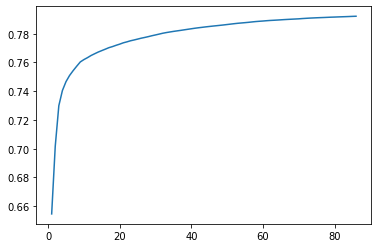

In [39]:
plt.plot(range(1, len(sfs.subsets_)+1), result)

In [31]:
prev_features = None
for key, value in sfs.subsets_.items():
    if prev_features is None:
        prev_features = [value['feature_idx'][0]]
    else:
        prev_features += [next(iter(set(value['feature_idx']) - set(prev_features)))]

In [51]:
i = 20
np.array(picks)[np.array(sfs.subsets_[i]['feature_idx'])]

array(['tf_lemma', 'log_CDcount', 'log_SUBTLWF', 'log_tf_lemma',
       'glove_word_277', 'log_tf_summed_bpe', 'log_google_ngram_2_head',
       'glove_word_151', 'glove_word_279', 'tfidf', 'glove_word_268',
       'elmo_word_541', 'elmo_word_726', 'is_acronym', 'elmo_word_646',
       'glove_word_284', 'glove_word_285', 'elmo_word_209',
       'glove_word_33', 'elmo_word_99'], dtype='<U26')

In [3]:
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import GridSearchCV

In [7]:
model = LinearRegression()
model.fit(X_picks, y)

SVR(kernel='sigmoid')

In [ ]:
model = SVR()
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=custom_cv_folds(single_train, n_splits=5), scoring=make_scorer(pearson), verbose=3)
grid.fit(X_picks, y)

In [ ]:
X_picks.shape

In [88]:
np.array(picks)[np.array(sfs.subsets_[150]['feature_idx'])]
#np.array(sfs.subsets_[150]['feature_idx'])

array(['tf_summed_bpe_sum', 'Lg10CD_sum', 'log_tf_lemma_sum',
       'log_Cdlow_head', 'log_CDcount_tail', 'log_tf_head',
       'log_FREQcount_head', 'glove_word_head_277', 'log_FREQlow_tail',
       'FREQlow_tail', 'SUBTLWF_tail', 'glove_word_sum_201',
       'glove_word_head_173', 'log_google_ngram_2_head_sum',
       'log_tf_ngram_2_head', 'log_tf_ngram_3_sum',
       'log_google_ngram_2_min_tail', 'glove_word_tail_151',
       'glove_word_tail_221', 'glove_word_head_210',
       'glove_word_tail_173', 'log_word_len_sum',
       'log_google_ngram_3_mid_sum', 'log_google_ngram_3_tail_head',
       'elmo_word_head_21', 'log_google_ngram_3_std_sum',
       'tfidf_ngram_3_tail', 'glove_word_head_236', 'log_tf_ngram_2_tail',
       'log_google_ngram_2_tail_sum', 'elmo_word_sum_488',
       'log_google_ngram_3_std_tail', 'glove_word_head_68',
       'glove_word_tail_207', 'log_tfidf_ngram_3_tail',
       'google_ngram_3_head_head', 'glove_word_sum_215',
       'log_google_ngram_3_head_ta